# Start up

The heavy lifting code is in other .py files in this directory

In [1]:
import iocommon
import logging
import matplotlib.pyplot as plt
import pandas as pd
import takeoffs

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 12]


# Load data
## Load from CSV (very expensive)

In [2]:
# data = iocommon.open_all_directory('/Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs', match='*.csv')

## Load from feather file (much faster)

In [3]:
data = pd.read_feather('/Users/mfdutra/Documents/flights.feather')

## Save new data to a feather file

If you loaded more stuff via CSV, save the whole data set again to a feather file.

In [4]:
# data.to_feather('/Users/mfdutra/Documents/flights.feather')

# Difference between first and last data point

In [5]:
data.iloc[-1]['DateTime'] - data.iloc[0]['DateTime']

Timedelta('349 days 07:31:10')

# Columns present in the data

In [6]:
sorted(data.columns)

['AfcsOn',
 'AltGPS',
 'AltInd',
 'AltMSL',
 'AtvWpt',
 'BaroA',
 'COM1',
 'COM2',
 'CRS',
 'DateTime',
 'E1 %Pwr',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 CHT5',
 'E1 CHT6',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'E1 EGT5',
 'E1 EGT6',
 'E1 FFlow',
 'E1 ITT',
 'E1 MAP',
 'E1 NG',
 'E1 OilP',
 'E1 OilT',
 'E1 RPM',
 'E1 TIT1',
 'E1 TIT2',
 'E1 Torq',
 'E2 FFlow',
 'E2 ITT',
 'E2 MAP',
 'E2 NG',
 'E2 RPM',
 'E2 Torq',
 'FQtyL',
 'FQtyR',
 'GPSfix',
 'GndSpd',
 'HAL',
 'HCDI',
 'HDG',
 'HPLfd',
 'HPLwas',
 'HSIS',
 'IAS',
 'LatAc',
 'Latitude',
 'Longitude',
 'MagVar',
 'NAV1',
 'NAV2',
 'NormAc',
 'OAT',
 'PichC',
 'Pitch',
 'PitchM',
 'Roll',
 'RollC',
 'RollM',
 'TAS',
 'TRK',
 'VAL',
 'VCDI',
 'VPLwas',
 'VSpd',
 'VSpdG',
 'WndDr',
 'WndSpd',
 'WptBrg',
 'WptDst',
 'amp1',
 'volt1',
 'volt2']

# Find all takeoffs in the data

Since the Cirrus doesn't have a weight on wheels sensor, takeoffs have to be inferred in the data.

We look at all data points where IAS is between 50 and 75. When we find the first one, we look at the acceleration over the next 30 seconds (or whatever 'future' is set to). If the airplane gained at least 10 knots, this is a takeoff.

Possible false positives: slow flights and stall practices

Possible false negatives: touch and goes

In [7]:
takeoff_number, takeoff_data = takeoffs.find_all_takeoffs(data)

print('Detected %d takeoffs' % takeoff_number)

Detected 914 takeoffs


# Analyze the takeoffs

## RPM

## Oil pressure and temperature

count    27420.000000
mean        80.675049
std          4.362535
min         48.200000
25%         78.180000
50%         80.420000
75%         83.350000
max         97.410000
Name: E1 OilP, dtype: float64


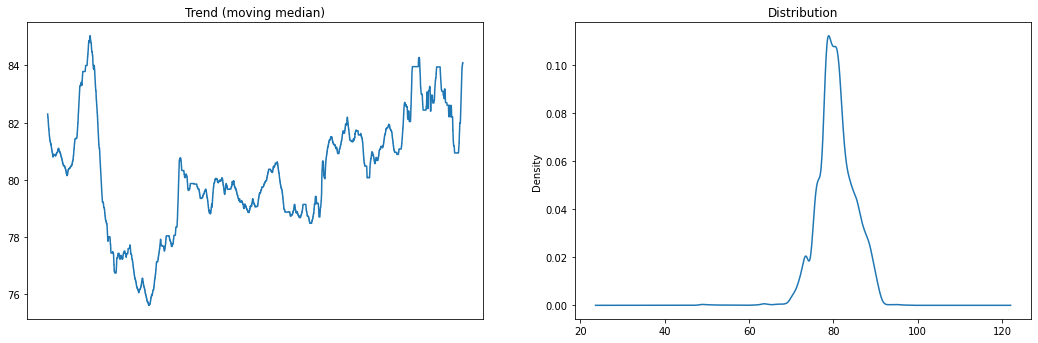

In [8]:
takeoffs.to_analyze(takeoff_data['E1 OilP'])

count    27420.000000
mean       177.203763
std         17.831532
min        116.490000
25%        166.297500
50%        183.310000
75%        189.530000
max        214.080000
Name: E1 OilT, dtype: float64


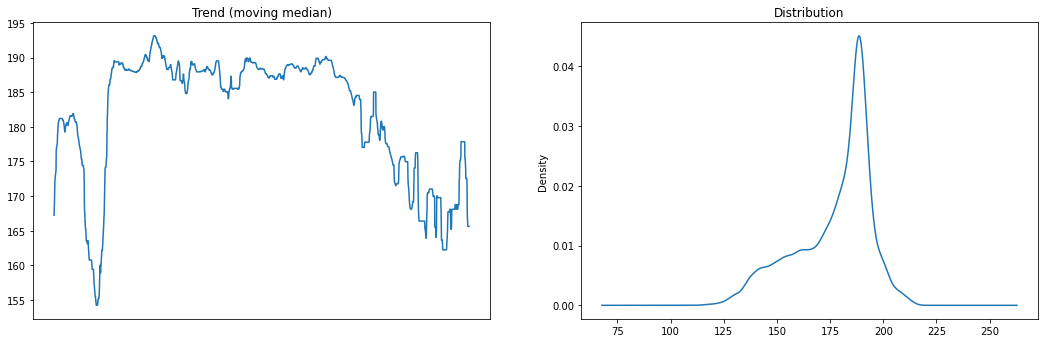

In [9]:
takeoffs.to_analyze(takeoff_data['E1 OilT'])

## Fuel flow

For naturally aspirated engines, fuel flow will be lower with altitude, so you may see a higher distribution.

count    27420.000000
mean        18.748633
std          2.541432
min          1.440000
25%         19.240000
50%         19.730000
75%         19.900000
max         20.800000
Name: E1 FFlow, dtype: float64


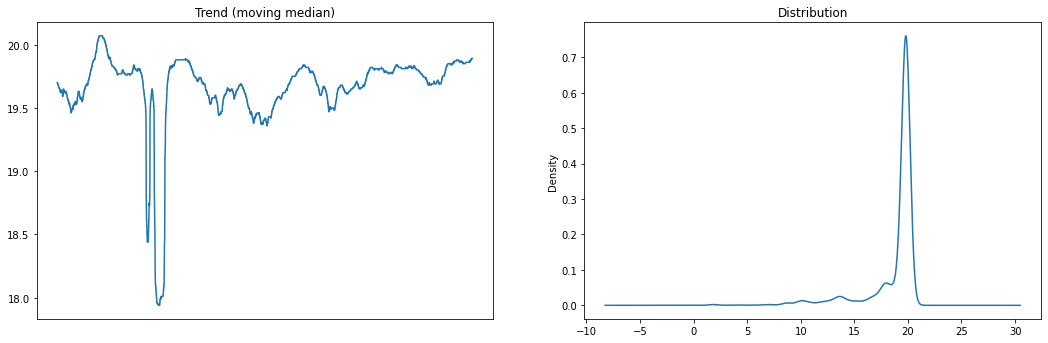

In [10]:
takeoffs.to_analyze(takeoff_data['E1 FFlow'])

## RPM

count    27420.000000
mean      2633.070879
std         90.213781
min        864.400000
25%       2649.800000
50%       2655.600000
75%       2660.900000
max       2701.400000
Name: E1 RPM, dtype: float64


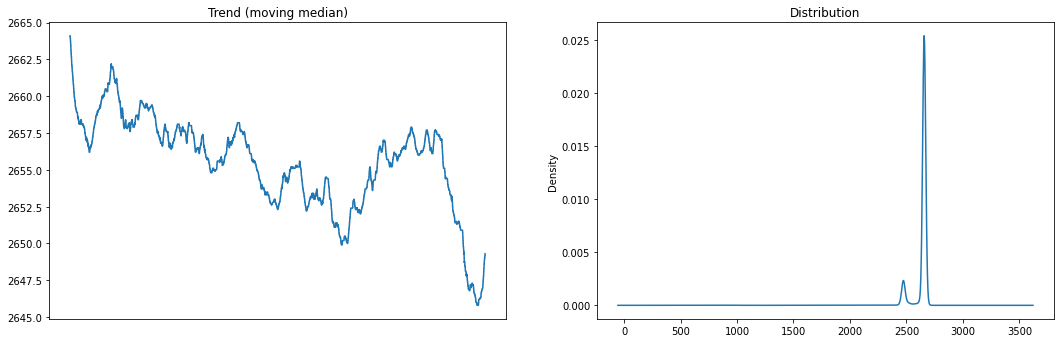

In [11]:
takeoffs.to_analyze(takeoff_data['E1 RPM'])

## EGT

            E1 EGT1       E1 EGT2       E1 EGT3       E1 EGT4
count  27420.000000  27420.000000  27420.000000  27420.000000
mean    1294.400217   1308.554633   1283.168371   1308.976807
std       44.000499     53.486913     45.700692     44.931259
min      890.230000    800.210000    878.140000    926.970000
25%     1280.320000   1294.480000   1270.410000   1294.310000
50%     1299.770000   1317.880000   1287.990000   1313.380000
75%     1312.230000   1332.740000   1300.200000   1327.812500
max     1541.280000   1538.310000   1522.980000   1540.810000


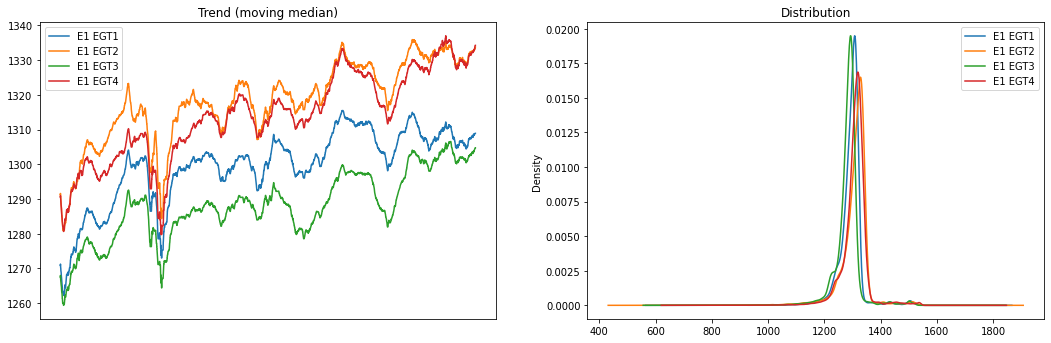

In [12]:
takeoffs.to_analyze(takeoff_data[['E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4']])

## CHT

            E1 CHT1       E1 CHT2       E1 CHT3       E1 CHT4
count  27420.000000  27420.000000  27420.000000  27420.000000
mean     305.054881    301.769667    319.971201    319.268813
std       21.062854     20.806440     21.115654     21.772725
min      234.960000    228.580000    249.800000    242.310000
25%      290.790000    287.750000    305.637500    304.190000
50%      302.840000    299.770000    317.110000    317.250000
75%      316.250000    312.680000    331.270000    331.500000
max      387.700000    377.200000    402.930000    398.960000


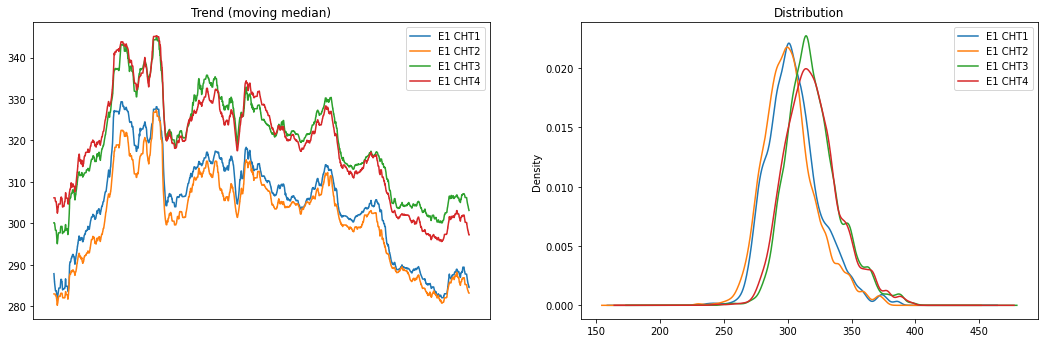

In [13]:
takeoffs.to_analyze(takeoff_data[['E1 CHT1', 'E1 CHT2', 'E1 CHT3', 'E1 CHT4']])